# Обучение распознавателя цифр методом AdaBoost
В рамках данного практического задания мы обучим распознаватель цифр с помощью метода машинного обучения AdaBoost (https://en.wikipedia.org/wiki/AdaBoost)

В качестве обучающего набора будем использовать рукопечатные цифры из **Optical recognition of handwritten digits dataset**, доступного для загрузки через **sklearn.datasets.load_digits**

Так как AdaBoost позволяет обучить бинарный классификатор, то мы обучим 10 бинарных классификаторов (для каждой цифры отдельный классификатор) и будем возвращать ответ распознавания по результатам применения каждого классификатора к исследуемому образцу. Пусть $SC_0, SC_1, ..., SC_9$ - классификаторы, обученные с помощью AdaBoost для каждой цифры. Так как $SC_i$ представим в виде линейной комбинации слабых классификаторов, то область значения - множество действительных чисел. Поэтому в качестве ответа будем возвращать значение цифры, для которой обученный классификатор вернул наибольшее значение.

In [80]:
import numpy as np
from tqdm import tqdm
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [81]:
class Wc:
    """ Weak classifier """

    def __init__(self, x, y, step_x, step_y, parity):
        self.x = x
        self.y = y
        self.step_x = step_x
        self.step_y = step_y
        self.parity = parity
   
    def compute(self, image):
        return +1 if self.parity * image[self.y][self.x] > \
                    image[self.y + self.step_y][self.x + self.step_x] else -1

class Sc:
    """ Strong classifier """

    def __init__(self):
        self.wc_list = []
        self.alpha_list = []

    def append_wc(self, wc, alpha):
        self.wc_list.append(wc)
        self.alpha_list.append(alpha)

    def compute(self, image):
        sum = 0
        for i in range(len(self.wc_list)):
            sum += self.alpha_list[i] * self.wc_list[i].compute(image)
        return sum


In [82]:
def train_sc_adaboost(positive_samples, negative_samples, wc_list, n_estimators=10):
    sc = Sc()
    
    labels = [1]*len(positive_samples) + [-1]*len(negative_samples)
    samples = positive_samples + negative_samples
    n = len(samples)
    weights = np.ones(n) / np.ones(n).sum()
    
    for _ in tqdm(range(n_estimators)):
        errs = []
        for wc in wc_list:
            err = sum([weights[i] for i in range(n) if wc.compute(samples[i]) != labels[i]])
            errs.append(err)

        err_min = min(errs)
        wc_to_add = wc_list[np.argmin(errs)]
        alpha_to_add = np.log((1 - err_min) / err_min) / 2
        sc.append_wc(wc_to_add, alpha_to_add)
        
        for i in range(n):
            weights[i] *= np.exp(-labels[i]*alpha_to_add*wc_to_add.compute(samples[i]))
        
        weights = weights / weights.sum()
    
    return sc 

In [83]:
def predict_adaboost(sc_list, images):
    pred_digits = []
    for image in images:
        best_digit = 0
        best_result = sc_list[0].compute(image)
        
        for digit, sc in enumerate(sc_list):
            result = sc.compute(image)
            if result > best_result:
                best_result = result
                best_digit = digit
                
        if best_result < 0:
            best_digit = -1
            
        pred_digits.append(best_digit)
        
    return pred_digits

In [84]:
def join_all_except_one(array, index):
    ans_array = []
    for i, subarray in enumerate(array):
        if i != index:
            ans_array.extend(subarray)
            
    return ans_array

---

<Figure size 432x288 with 0 Axes>

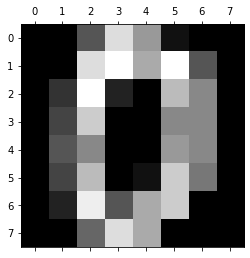

In [85]:
all_digits = load_digits()

plt.gray()
plt.matshow(all_digits.images[0]) 

In [86]:
all_digits_images = []

for digit in range(10):
    digit_images = [image for image, target in zip(all_digits.images, all_digits.target) if target == digit]
    all_digits_images.append(digit_images)

In [87]:
digits_images_train = []
digits_images_test = []

for digit in range(10):
    train, test = train_test_split(all_digits_images[digit], test_size=0.3, random_state=777)
    digits_images_train.append(train)
    digits_images_test.append(test)

In [88]:
image_wd = 8
image_ht = 8

wc_list = []
for y in range(image_ht):
    for x in range(image_wd):
        if x + 1 < image_wd:
            wc_list.append(Wc(x, y, 1, 0, +1))
            wc_list.append(Wc(x, y, 1, 0, -1))
        if x + 2 < image_wd:
            wc_list.append(Wc(x, y, 2, 0, +1))
            wc_list.append(Wc(x, y, 2, 0, -1))
        if y + 1 < image_ht:
            wc_list.append(Wc(x, y, 0, 1, +1))
            wc_list.append(Wc(x, y, 0, 1, -1))
        if y + 2 < image_ht:
            wc_list.append(Wc(x, y, 0, 2, +1))
            wc_list.append(Wc(x, y, 0, 2, -1))

In [132]:
opt_est_nums = [30, 70, 40, 80, 40, 40, 30, 40, 70, 70]

In [134]:
sc_list = []
for digit in range(10):
    positive_samples = digits_images_train[digit]
    negative_samples = join_all_except_one(digits_images_train, digit)
    sc = train_sc_adaboost(positive_samples, negative_samples, wc_list, opt_est_nums[digit])
    sc_list.append(sc)

100%|██████████| 70/70 [00:43<00:00,  1.61it/s]


In [135]:
digits_pred = []
digits_true = []
accuracy_per_digit = []
for digit in range(10):
    pred = predict_adaboost(sc_list, digits_images_test[digit])
    true = [digit] * len(pred)
    
    accuracy_per_digit.append(accuracy_score(true, pred))
    
    digits_pred.extend(pred)
    digits_true.extend(true)

final_accuracy = accuracy_score(digits_true, digits_pred)

for digit in range(10):
    print('{}: {:.2}'.format(digit, accuracy_per_digit[digit]))
print()
print('Final accuracy:', round(final_accuracy, 2))

0: 0.93
1: 0.38
2: 0.85
3: 0.76
4: 0.85
5: 0.89
6: 0.91
7: 0.87
8: 0.7
9: 0.8

Final accuracy: 0.79


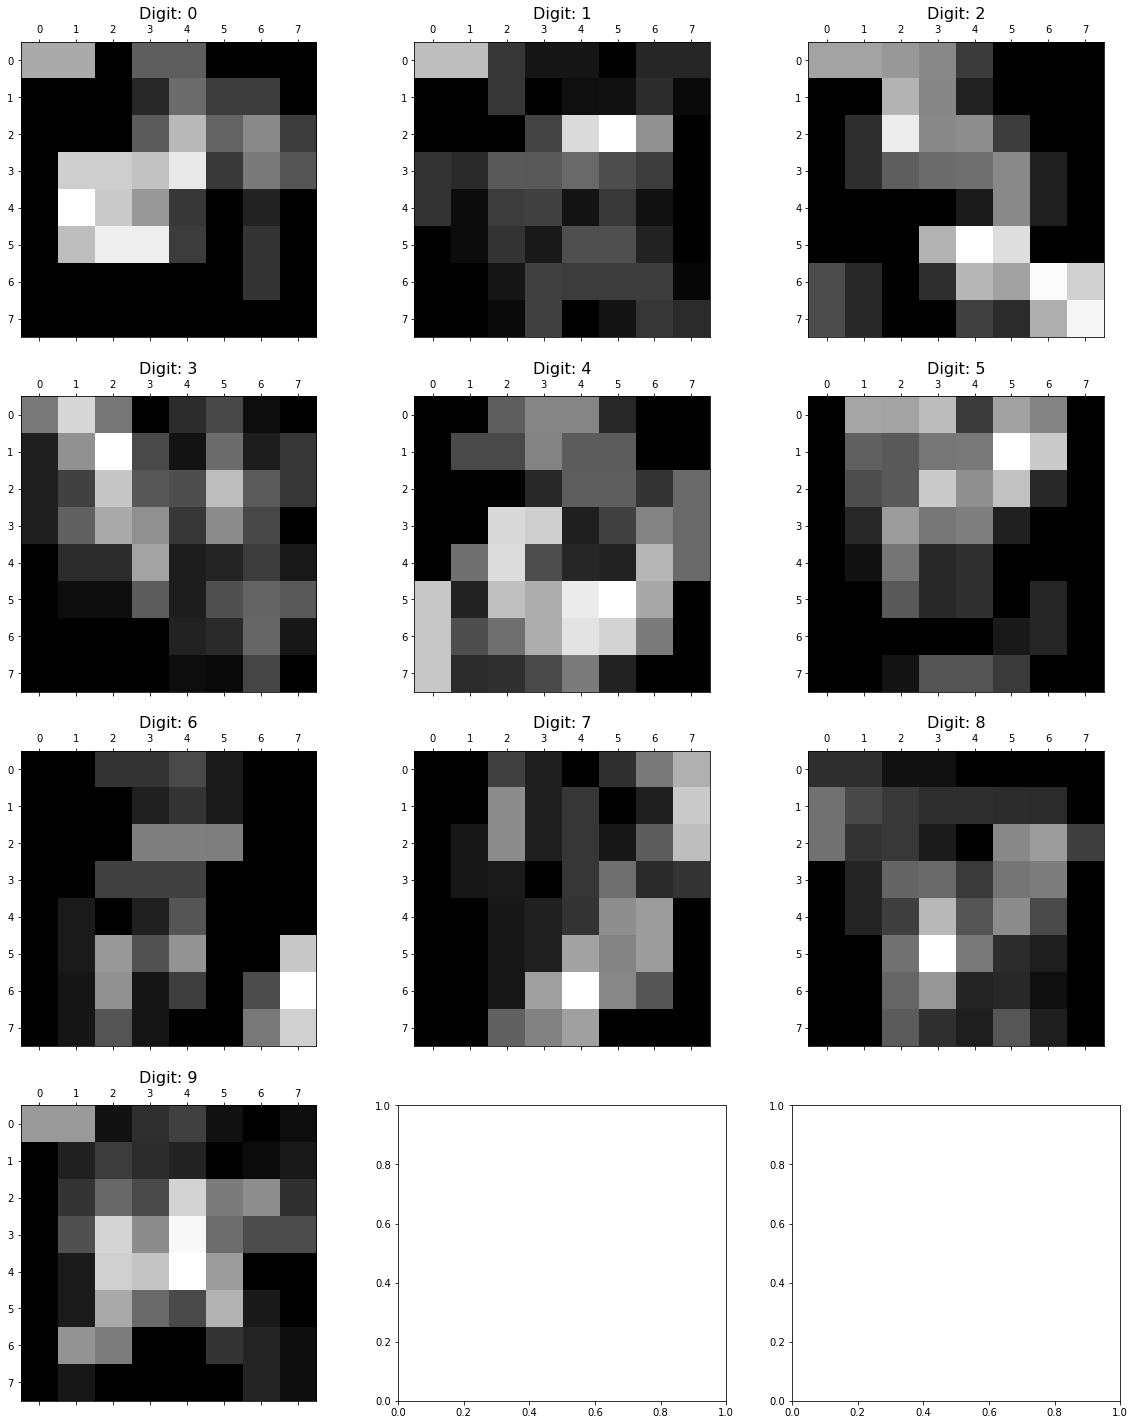

In [139]:
fig, axes = plt.subplots(4, 3, figsize=(20, 25))
for digit in range(10):
    freq_matrix = np.zeros((image_ht,image_wd))
    for wc, alpha in zip(sc_list[digit].wc_list, sc_list[digit].alpha_list):
        #freq_matrix[wc.y][wc.x] += alpha
        for step_x in range(wc.step_x + 1):
            for step_y in range(wc.step_y + 1):
                freq_matrix[wc.y + step_y][wc.x + step_x] += alpha
              
    axes[digit // 3, digit % 3].matshow(freq_matrix)
    axes[digit // 3, digit % 3].set_title('Digit: ' + str(digit), fontsize=16)

---

In [28]:
est_nums = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
digit_scores = []
for digit in range(10):
    scores = []
    for est_num in tqdm(est_nums):
        positive_samples = digits_images_train[digit]
        negative_samples = join_all_except_one(digits_images_train, digit)
        sc = train_sc_adaboost(positive_samples, negative_samples, wc_list, est_num)
        
        samples = positive_samples + negative_samples
        true = [1] * len(positive_samples) + [-1] * len(negative_samples)
        pred = [np.sign(sc.compute(sample)) for sample in samples]
        
        scores.append(accuracy_score(true, pred))
        
    digit_scores.append(scores)

100%|██████████| 10/10 [05:30<00:00, 33.04s/it]


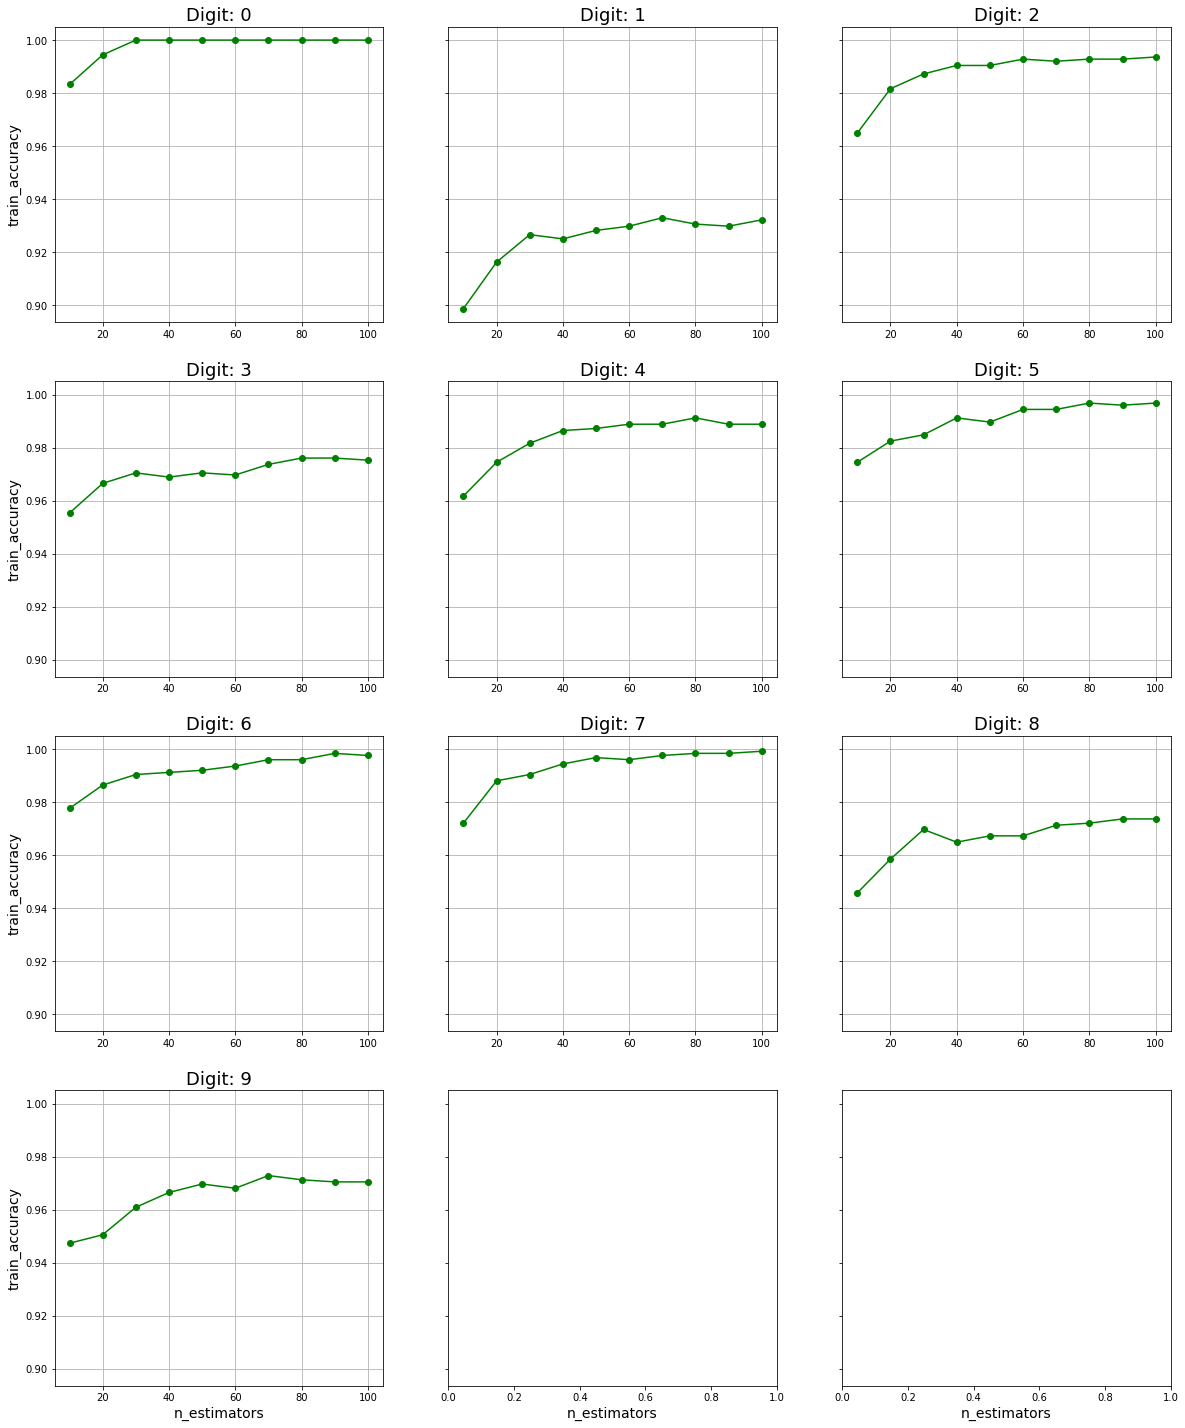

In [78]:
fig, axes = plt.subplots(4, 3, figsize=(20, 25), sharey=True)
axes[-1, -1].set_xlabel('n_estimators', fontsize=14)
axes[-1, -2].set_xlabel('n_estimators', fontsize=14)

for digit, scores in enumerate(digit_scores):
    axes[digit // 3, digit % 3].plot(est_nums, scores, 'o-', c='green')
    
    axes[digit // 3, digit % 3].set_title('Digit: ' + str(digit), fontsize=18)
    axes[digit // 3, digit % 3].grid()
    if digit % 3 == 0: 
        axes[digit // 3, digit % 3].set_ylabel('train_accuracy', fontsize=14)
    if digit // 3 == 3:
        axes[digit // 3, digit % 3].set_xlabel('n_estimators', fontsize=14)